In [35]:
#!/bin/PYTHONscript
###### HEADER ############################################
# Author:  Thomas Frölicher (thomas.froelicher@unibe.ch)
#          Erich M. Fischer (erich.fischer@env.ethz.ch)
#          Joel Zeder (joel.zeder@env.ethz.ch)
#          Natacha Le Grix (natacha.legrix@unibe.ch)
#.         Jitendra Singh (jitendra.singh@env.ethz.ch)
# Date:    01.09.24 and 06.09.2024
# Purpose: Detection and Attribution Exercise (Swiss Climate Summer School 2024)

In [36]:
#### LOAD LIBRARIES ##########################################################
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import genextreme as gev
from scipy.stats import rankdata
from scipy.stats import genextreme as gev

In [37]:
# Settings
path_data_in = "~/Data_Input/"
## Select input data (by un-commenting the respective line):
##Western Europe Drought - regional and local (Lyon gridpoint):
DA_data_path = os.path.join(path_data_in, "drought_we", "WesternEurope_Drought.csv")
#DA_data_path = os.path.join(path_data_in, "drought_we", "Lyon_Drought.csv")

# Read input data
DA_data_df = pd.read_csv(DA_data_path)
DA_data_df['model'] = DA_data_df['model'].astype('category')
DA_data_df['ens'] = DA_data_df['ens'].astype('category')

# Filter for observations in 2022
DA_obs2022_df = DA_data_df[(DA_data_df['year'] == 2022) & (DA_data_df['model'] == 'ERA5')]
#DA_obs2022_df # View data structure: UNCOMMENT TO PRINT
#DA_data_df # View data structure: UNCOMMENT TO PRINT

## ----------  DON'T UNCOMMENT THIS SECTION -----------------------------------------------
## How does the data look like?
## One data.frame with columns
## "model"     - models depending on location/variable
## "ens"       - ensemble member, always 1 for ERA5 or satellite observations
## "year"      - model or observation year
## <index>     - the extreme value index (e.g. P-E , ...)
## <index_ano> - anomaly against 1981 - 2010 baseline (e.g. JJA average)
## "gmst_ano"  - smoothed GMST anomaly against 1981 - 2010


In [38]:
### filter data based on model
data_by_model = [group for _, group in DA_data_df[DA_data_df['model'].isin(['CanESM5', 'UKESM1'])].groupby('model')]
#data_by_model # grouping data by model name

/tmp/ipykernel_21697/2176982754.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data_by_model = [group for _, group in DA_data_df[DA_data_df['model'].isin(['CanESM5', 'UKESM1'])].groupby('model')]


In [ ]:
# Detection & attribution analysis starts here

In [39]:
# Function to estimate exceedance probabilities
def calculate_exceedance(data, period, obs2022, model_name):
    # Filter data for the specified period
    data_to_fit = data[(data['year'] >= period[0]) & (data['year'] <= period[1])]
    
    # Print debug information about the filtering process
    if data_to_fit.empty:
        print(f"Warning: No data available for the period {period}. Skipping GEV fit.")
        #print(f"Data received: {data[['year']].min()} to {data[['year']].max()}")
        return None
    else:
        print(f"Data available for the period {period}: {data_to_fit[['year']].min()} to {data_to_fit[['year']].max()}")
    
    fit_params = gev.fit(data_to_fit['p_e']) # Fit GEV distribution
 
    # Calculate exceedance probabilities using GEV
    sorted_ano = np.sort(data_to_fit['p_e'])
    exceed_prob_gev =  gev.cdf(sorted_ano, *fit_params)
    prob_obs2022_gev =  gev.cdf(obs2022, *fit_params)
   
    # Calculate empirical exceedance probabilities
    exceed_prob_empirical = 1 - np.array([(data_to_fit['p_e'] > ano).mean() for ano in sorted_ano])
    prob_obs2022_empirical = (data_to_fit['p_e'] <= obs2022).mean()
    
    # Create a DataFrame with the results, including model information
    exceedance_df = pd.DataFrame({
        'model': model_name,
        'year': data_to_fit['year'].iloc[np.argsort(data_to_fit['p_e'])].values,
        'p_e_arranged': sorted_ano,
        'p_e': data_to_fit['p_e'].values,
        'nonexceedProb': exceed_prob_gev,
        'nonexceedProb_EmpDist': exceed_prob_empirical,
        'nonexceedProb_obs2022': prob_obs2022_gev,
        'nonexceedProb_obs2022_EmpDist': prob_obs2022_empirical
    })    
    return exceedance_df

In [40]:
cFactPeriod = (1850, 1949) # define counter factual world; CHANGE HERE IF REQUIRED
FactPeriod = (1990, 2022) # define factual (or current) world; CHANGE HERE IF REQUIRED
FutPeriod = (2025, 2055) # define future world; CHANGE HERE IF REQUIRED

# Estimate exceedance probabilities for each model and period
cFact_stats = pd.concat([ calculate_exceedance(data, cFactPeriod, DA_obs2022_df['p_e'].values[0], data['model'].iloc[0]) for data in data_by_model if not data.empty])
Fact_stats = pd.concat([ calculate_exceedance(data, FactPeriod, DA_obs2022_df['p_e'].values[0], data['model'].iloc[0]) for data in data_by_model if not data.empty])
Fut_stats = pd.concat([ calculate_exceedance(data, FutPeriod, DA_obs2022_df['p_e'].values[0], data['model'].iloc[0]) for data in data_by_model if not data.empty])
#cFact_stats

Data available for the period (1850, 1949): year    1850
dtype: int64 to year    1949
dtype: int64
Data available for the period (1850, 1949): year    1850
dtype: int64 to year    1949
dtype: int64
Data available for the period (1990, 2022): year    1990
dtype: int64 to year    2022
dtype: int64
Data available for the period (1990, 2022): year    1990
dtype: int64 to year    2022
dtype: int64
Data available for the period (2025, 2055): year    2025
dtype: int64 to year    2055
dtype: int64
Data available for the period (2025, 2055): year    2025
dtype: int64 to year    2055
dtype: int64


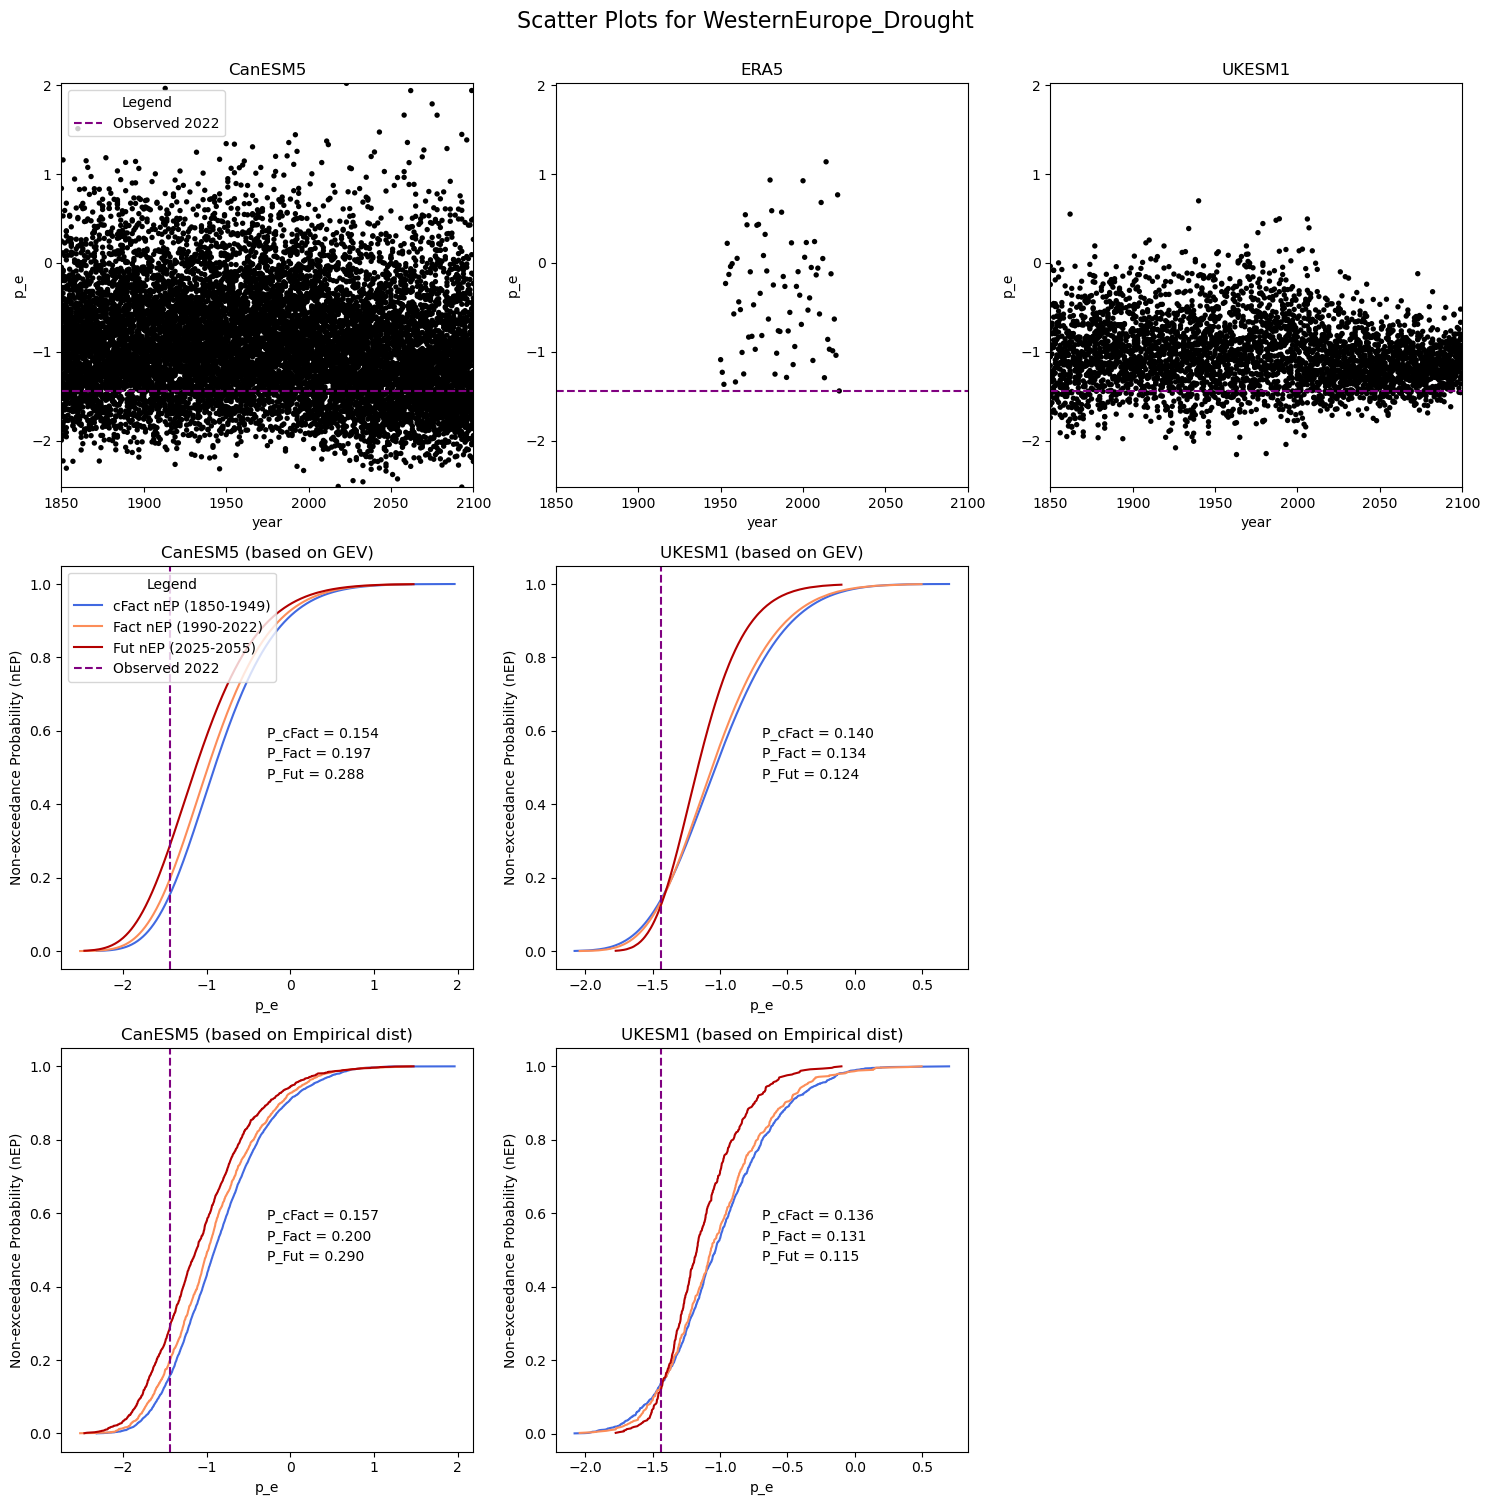

In [41]:
##################################
## Plot start here
####################################
plt.figure(figsize=(15, 15))

x_range = (1850, 2100) # Define x-axis range
y_range = (DA_data_df['p_e'].min(), DA_data_df['p_e'].max()) # Define y-axis range
plt.suptitle('Scatter Plots for ' + os.path.splitext(os.path.basename(DA_data_path))[0], fontsize=16, y=1)

# Scatter plots for all models 
for i, model in enumerate(['CanESM5', 'ERA5','UKESM1'], 1):
    plt.subplot(3, 3, i)
    sns.scatterplot(data=DA_data_df[DA_data_df['model'] == model], x='year', y='p_e', color='black', legend=False, s=15,  # Set smaller dot size
        edgecolor='none' )
    plt.axhline(DA_obs2022_df['p_e'].mean(), color='purple', linestyle='--', label='Observed 2022')
    #plt.title('Scatter Plots for ' + os.path.splitext(os.path.basename(DA_data_path))[0])
    plt.xlim(x_range)
    plt.ylim(y_range)  # Set y-axis range
    plt.title(f'{model}')
    if i == 1:
        plt.legend(title='Legend', loc='upper left')

# Line plots for exceedance probability (GEV) 
for i, model in enumerate(['CanESM5', 'UKESM1',], 1):
    plt.subplot(3, 3, 3 + i)
    sns.lineplot(data=cFact_stats[cFact_stats['model'] == model], x='p_e_arranged', y='nonexceedProb', color='#4169e1',label=f'cFact nEP ({cFactPeriod[0]}-{cFactPeriod[1]})')
    sns.lineplot(data=Fact_stats[Fact_stats['model'] == model], x='p_e_arranged', y='nonexceedProb', color='#fc8d59',label=f'Fact nEP ({FactPeriod[0]}-{FactPeriod[1]})')
    sns.lineplot(data=Fut_stats[Fut_stats['model'] == model], x='p_e_arranged', y='nonexceedProb', color='#b30000',label=f'Fut nEP ({FutPeriod[0]}-{FutPeriod[1]})')
    plt.axvline(DA_obs2022_df['p_e'].values[0], color='purple', linestyle='--', label='Observed 2022')
    plt.title(f'{model} (based on GEV)')
    plt.ylabel('Non-exceedance Probability (nEP)')
    plt.xlabel('p_e')
    # Add exceedance probabilities for obs2022
    exceed_prob_cFact = cFact_stats[cFact_stats['model'] == model]['nonexceedProb_obs2022'].iloc[0]
    exceed_prob_Fact = Fact_stats[Fact_stats['model'] == model]['nonexceedProb_obs2022'].iloc[0]
    exceed_prob_Fut = Fut_stats[Fut_stats['model'] == model]['nonexceedProb_obs2022'].iloc[0]
    
    plt.text(0.5, 0.6, f'P_cFact = {exceed_prob_cFact:.3f}', transform=plt.gca().transAxes, verticalalignment='top')
    plt.text(0.5, 0.55, f'P_Fact = {exceed_prob_Fact:.3f}', transform=plt.gca().transAxes, verticalalignment='top')
    plt.text(0.5, 0.5, f'P_Fut = {exceed_prob_Fut:.3f}', transform=plt.gca().transAxes, verticalalignment='top')

    if i == 1:
        plt.legend(title='Legend', loc='upper left')
    else:
        plt.legend([],[], frameon=False)  # Hide legend for the second panel

# Line plots for exceedance probability (Empirical) 
for i, model in enumerate(['CanESM5', 'UKESM1'], 1):
    plt.subplot(3, 3, 6 + i)
    sns.lineplot(data=cFact_stats[cFact_stats['model'] == model], x='p_e_arranged', color='#4169e1', y='nonexceedProb_EmpDist',label=f'cFact nEP ({cFactPeriod[0]}-{cFactPeriod[1]})')
    sns.lineplot(data=Fact_stats[Fact_stats['model'] == model], x='p_e_arranged', color='#fc8d59',y='nonexceedProb_EmpDist',label=f'Fact nEP ({FactPeriod[0]}-{FactPeriod[1]})')
    sns.lineplot(data=Fut_stats[Fut_stats['model'] == model], x='p_e_arranged', color='#b30000', y='nonexceedProb_EmpDist',label=f'Fut nEP ({FutPeriod[0]}-{FutPeriod[1]})')
    plt.axvline(DA_obs2022_df['p_e'].values[0], color='purple', linestyle='--')
    plt.title(f'{model} (based on Empirical dist)')
    plt.ylabel('Non-exceedance Probability (nEP)')
    plt.xlabel('p_e')
    # Add empirical exceedance probabilities for obs2022
    exceed_prob_emp_cFact = cFact_stats[cFact_stats['model'] == model]['nonexceedProb_obs2022_EmpDist'].iloc[0]
    exceed_prob_emp_Fact = Fact_stats[Fact_stats['model'] == model]['nonexceedProb_obs2022_EmpDist'].iloc[0]
    exceed_prob_emp_Fut = Fut_stats[Fut_stats['model'] == model]['nonexceedProb_obs2022_EmpDist'].iloc[0]

    plt.text(0.5, 0.6, f'P_cFact = {exceed_prob_emp_cFact:.3f}', transform=plt.gca().transAxes, verticalalignment='top')
    plt.text(0.5, 0.55, f'P_Fact = {exceed_prob_emp_Fact:.3f}', transform=plt.gca().transAxes, verticalalignment='top')
    plt.text(0.5, 0.5, f'P_Fut = {exceed_prob_emp_Fut:.3f}', transform=plt.gca().transAxes, verticalalignment='top')

    plt.legend([],[], frameon=False)  # Hide legend

plt.tight_layout()
plt.show()

######################################################################
# Save plot and output files (UNCOMMENT AND PROVIDE YOUR PATH)
######################################################################
#output_dir = 'YOUR PATH/GOES HERE' # Define the output directory
#os.makedirs(output_dir, exist_ok=True) # Create the directory if it doesn't exist
#base_name = os.path.splitext(os.path.basename(DA_data_path))[0] # Define basename for the plot
#plt.savefig(os.path.join(output_dir, f'{base_name}.png')) # save plot
#cFact_stats.to_csv(os.path.join(output_dir, 'cFact_stats.csv'), index=False) # save counter factual world stats
#Fact_stats.to_csv(os.path.join(output_dir, 'Fact_stats.csv'), index=False) # save factual (current) world stats
#Fut_stats.to_csv(os.path.join(output_dir, 'Fut_stats.csv'), index=False) # save future world stats